# Monitor WML Model With Watson OpenScale

<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

### Contents
- [Introduction](#intro)
- [Setup](#setup)
- [Fetch Model and Deployments](#model)
- [OpenScale configuration](#openscale)
- [Create Service Provider and Subscription](#subscription)
- [Quality monitor and feedback logging](#quality)
- [Fairness monitor](#fairness)
- [Explanations](#explain)
- [Drift monitoring](#drift)

## Introduction<a name="intro"></a>
In **1-model_train notebook**, we trained our Utilities customer attrition model and deployed it using WML. In this notebook, we will programmatically set up and configure OpenScale, create a data mart for the model with Watson OpenScale and configure OpenScale to monitor that deployment, and inject records and measurements for viewing in the OpenScale insights dashboard. Access to a relational database is required to monitor the model with openscale.


**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

## Setup <a name="setup"></a>

In the cells below we install/import the python libraries that we will use throughout the notebook.`ibm_watson_openscale` is a python library that allows to work with [Watson OpenScale services](http://ai-openscale-python-client.mybluemix.net/) on IBM Cloud Pak for Data. 
 

In [1]:
import os
import datetime
import base64
import json
import requests

from ibm_watson_machine_learning import APIClient
import pandas as pd

# use this library for reading and saving data in CP4D
from project_lib import Project
project = Project()

### User Inputs
#### 1. WOS Credentials
Enter Credentials for your CPD cluster in the below cell.

In [2]:
# Sample crendential
# WOS_CREDENTIALS = {"url":"https://example.cluster.com"
#                   "username":"user1",
#                   "password":"password"}

WOS_CREDENTIALS = {
    "url": "",
    "username": "",
    "password": ""
}

#### 2. Database Credentials
Access to a relational database is required to store the openscale payloads and results.
Enter Credentials for your DB2/PostgreSQL database in the below cell. Free DB2/PostgreSQL Database can be created using the IBM Cloud Dashboard catalog.

To provision a new instance of Db2 Warehouse:

- Locate Db2 Warehouse in the Cloud catalog
- Give your service a name, and click Create.
- Once your instance is created, click the Service Credentials link on the left side of the screen.
- Click the New credential button, give your credentials a name, and click Add.
- Your new credentials can be accessed by clicking the View credentials button.
- Copy and paste your Db2 Warehouse credentials into the cell below.

In [3]:
DATABASE_CREDENTIALS = {
    "db_type": "db2",
    "host": "",
    "username": "",
    "password": "",
    "port": ,
    "database": "",
    "ssl":False,
#   "sslmode":"verify-full",
#   "certificate_base64":"***"

}
SCHEMA_NAME = ""
table_name = "UTILITIES_ATTRITION_VIEW"

Alternatively, Database credentials can also be created by adding a new connection in the project data assets. Created connection can be imported using `project_lib` library. Uncomment below cell if connection is created in the data assets. Make sure all the items in the above `DATABASE_CREDENTIALS` dictionary are available in the imported connection.

In [4]:
#DATABASE_CREDENTIALS=project.get_connection(name="DB2_Connection")

#### 3. Model and Deployment
Enter the details of the models deployed in the **1-model_training** notebook in the below cell.

In [5]:
space_name = 'Utilities Customer Attrition with OpenScale Space'
MODEL_NAME = 'Utilities Customer Attrition Model'
deployment_name = 'Utilities Customer Attrition Model Deployment'

Apart from these inputs, the following details can also be updated while running the notebook.

1. Columns used in the model and the target column details in [Create Subscription](#subscription) section.
2. Favourable class, unfavourable class, features to monitor bias for, majority and minority columns for bias in [Fairness monitor](#fairness) section .

## Fetch Model and Deployments <a name="model"></a>
Fetch the deployment space and model deployment from above specifications and assign the default space.

In [6]:
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='3.5'


from ibm_watson_machine_learning import APIClient

token = os.environ['USER_ACCESS_TOKEN']

wml_client = APIClient(WML_CREDENTIALS)


l_space_details = []
l_space_details_created_times = []
for space_details in wml_client.spaces.get_details()['resources']:
    if space_details['entity']['name'] == space_name:
        space_id=space_details['metadata']['id']

# set this space as default space
wml_client.set.default_space(space_id)

'SUCCESS'

Get the deployment id and model id for the model in the current space.

In [7]:
l_deployment_details = []
l_deployment_details_created_times = []

for deployment in wml_client.deployments.get_details()['resources']:
        if deployment['entity']['name'] == deployment_name:            
                l_deployment_details.append(deployment)
                l_deployment_details_created_times.append(datetime.datetime.strptime(deployment['metadata']['created_at'],  '%Y-%m-%dT%H:%M:%S.%fZ'))
                

# get the index of the latest created date from the list and use that to get the deployment_id
list_latest_index = l_deployment_details_created_times.index(max(l_deployment_details_created_times))
deployment_uid = l_deployment_details[list_latest_index]['metadata']['id']
fields=wml_client.deployments.get_details(deployment_uid)['entity']['custom']
model_uid=wml_client.deployments.get_details(deployment_uid)['entity']['asset']['id']

The data that used to train the model is stored in `/project_data/data_asset/` folder. Below cells read the data into a pandas dataframe and loads sample records into a Database table. This table will be used as a `training_data_reference` through out the notebook.

In [8]:
my_file = project.get_file('utilities-customer-attrition-prediction_view.csv')
my_file.seek(0)
pd_data = pd.read_csv(my_file)
pd_data=pd_data.dropna()

all_fields=fields[:]
all_fields.append("ATTRITION_STATUS")

Below cell loads sample training data into a DB2 Table. This sample data can be used for scoring and drift configurations. **If there is already a table in DB2 instance with sample training records then skip this step.**

In [9]:
#import ibm_db
#from sqlalchemy import create_engine
#dsn_driver = "IBM DB2 ODBC DRIVER"
#dsn_protocol="TCPIP"

#engine = create_engine('ibm_db_sa://'+ DATABASE_CREDENTIALS['username'] + ':' + DATABASE_CREDENTIALS['password'] + '@'+DATABASE_CREDENTIALS['host']+':'+str(DATABASE_CREDENTIALS['port'])+'/' + DATABASE_CREDENTIALS['database'] )
#pd_data[all_fields].sample(5000).to_sql(table_name, engine,index=False,if_exists='replace')

## Configure OpenScale <a name="openscale"></a>

Once we have all the user inputs, now we can configure OpenScale. These are the set of steps involved in configuring OpenScale.
1. Create an api client to start working with client library using WOS credentials .
2. If a data mart doesn't exist Create or Update a data mart using Database credentials on the api client.
3. Create a binding between the api client and the wml instances.
4. List all the existing bindings.
5. Create and manage subscriptions of machine learning models deployments.

In [10]:
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator
from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

authenticator = CloudPakForDataAuthenticator(
        url=WOS_CREDENTIALS["url"],
        username=WOS_CREDENTIALS["username"],
        password=WOS_CREDENTIALS["password"],
        disable_ssl_verification=True
    )
wos_client = APIClient(authenticator=authenticator, service_url=WOS_CREDENTIALS["url"])

### Create/Set up datamart

Watson OpenScale uses a database to store payload logs and calculated metrics. The datamart will be created with the database credentials provided above unless there is an existing datamart. If there is an existing data mart, it will be used throughout this notebook.

In [11]:
wos_client.data_marts.show()
data_marts = wos_client.data_marts.list().result.data_marts
if len(data_marts) == 0:
    if DATABASE_CREDENTIALS is not None:
        if SCHEMA_NAME is None: 
            print("Please specify the SCHEMA_NAME and rerun the cell")

        print('Setting up external datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by Utilities Customer Attrition Industry Accelerator",
                database_configuration=DatabaseConfigurationRequest(
                  database_type=DatabaseType.DB2,
                    credentials=PrimaryStorageCredentialsLong(
                        hostname=DATABASE_CREDENTIALS['host'],
                        username=DATABASE_CREDENTIALS['username'],
                        password=DATABASE_CREDENTIALS['password'],
                        db=DATABASE_CREDENTIALS['database'],
                        port=DATABASE_CREDENTIALS['port'],
                        ssl=DATABASE_CREDENTIALS['ssl']
                    #    sslmode=DATABASE_CREDENTIALS['sslmode'],
                    #    certificate_base64=DATABASE_CREDENTIALS['certificate_base64']
                    ),
                    location=LocationSchemaName(
                        schema_name= SCHEMA_NAME
                    )
                )
             ).result
    else:
        print('Setting up internal datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by Utilities Customer Attrition Industry Accelerator", 
                internal_database = True).result
        
    data_mart_id = added_data_mart_result.metadata.id
    
else:
    data_mart_id=data_marts[0].metadata.id
    print('Using existing datamart {}'.format(data_mart_id))

None,None,False,active,2021-05-11 10:52:30.237000+00:00,00000000-0000-0000-0000-000000000000


Using existing datamart 00000000-0000-0000-0000-000000000000


### Service Provider <a name="subscription"></a>

Once the data mart is setup, we can now create and manage service providers of  models deployments. Service Providers binds Watson OpenScale to the Watson Machine Learning instance to capture payload data into and out of the model. It involves following steps.
1. List all the service providers for the WOS client.
2. Delete if a service provider already exists for the model.
3. Create a new service provider.

In [12]:
SERVICE_PROVIDER_NAME='Utilities Customer Attrition WML INSTANCE'
SERVICE_PROVIDER_DESCRIPTION = "Added by Utilities Customer Attrition Industry Accelerator"

In [13]:
service_providers = wos_client.service_providers.list().result.service_providers


service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for WML instance: {}".format(service_provider_id))

Deleted existing service_provider for WML instance: 4becec17-5af3-4519-8228-edaa7223021a


In [14]:
added_service_provider_result = wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description=SERVICE_PROVIDER_DESCRIPTION,
        service_type=ServiceTypes.WATSON_MACHINE_LEARNING,
        deployment_space_id = space_id,
        operational_space_id = "production",
        credentials=WMLCredentialsCP4D(
            instance_id=WML_CREDENTIALS["instance_id"],
            url=WML_CREDENTIALS["url"],
            username=WML_CREDENTIALS["username"],
            password=WML_CREDENTIALS["password"]
        ),
        background_mode=False
    ).result
service_provider_id = added_service_provider_result.metadata.id




 Waiting for end of adding service provider beb343a1-17d5-4fef-9fc4-2a1d3f243d63 




active

-----------------------------------------------
 Successfully finished adding service provider 
-----------------------------------------------




In [15]:
wos_client.service_providers.show()

99999999-9999-9999-9999-999999999999,active,Utilities Customer Attrition WML INSTANCE,watson_machine_learning,2021-05-13 10:18:50.585000+00:00,beb343a1-17d5-4fef-9fc4-2a1d3f243d63
99999999-9999-9999-9999-999999999999,active,WML Utiities Attrition,watson_machine_learning,2021-05-11 10:52:55.695000+00:00,14d95542-91e1-4f5e-b192-c0145138acca


### Subscriptions

This code creates the model subscription in OpenScale using the Python client API. 
In order to create a new subscription we will need to provide following details
1. `Model details` including Model id, type, input_data_type(STRUCTURED or UNSTRUCTURED), Problem type(BINARY_CLASSIFICATION, REGRESSION, MULTI_CLASSIFICATION)
2. `Model deployment details` including deployment name, id, type, url.
3. `Training Data Reference`: training data specified in the user inputs cell
4. `Asset Properties`: <br>
    a. label_column: Prediction column name.<br>
    b. feature_fields: Columns used in the training data set.<br>
    c. categorical_fields: set of Catgorical columns in the training data set.<br>


When a subscription is successfully created, we should be able to see it in the path `{HOST}/aiopenscale/insights`.

In [16]:
deployment=wml_client.deployments.get_details(deployment_uid)
asset = Asset(
    asset_id=model_uid,
    url=deployment["entity"]["status"]["online_url"]["url"],
    asset_type=AssetTypes.MODEL,
    input_data_type=InputDataType.STRUCTURED,
    problem_type=ProblemType.BINARY_CLASSIFICATION
)
asset_deployment = AssetDeploymentRequest(
    deployment_id=deployment_uid,
    name=deployment_name,
    deployment_type=DeploymentTypes.ONLINE,
    url=deployment["entity"]["status"]["online_url"]["url"]
)


#CP4D DB2 example format
training_data_reference = TrainingDataReference(
        type="db2",
           
            connection= DATABASE_CREDENTIALS,
            location= {
                "tablename": table_name,
                "schema_name": SCHEMA_NAME
            }
    
)

print("Creating Asset Properties..")
asset_properties_request = AssetPropertiesRequest(
    label_column="ATTRITION_STATUS",
    probability_fields=["probability"],
    prediction_field="prediction",
    feature_fields=[ "GENDER_ID", "AGE", "ENERGY_USAGE_PER_MONTH", "ENERGY_EFFICIENCY", "IS_REGISTERED_FOR_ALERTS", "OWNS_HOME", "COMPLAINTS", "HAS_THERMOSTAT", "HAS_HOME_AUTOMATION", "PV_ZONING", "WIND_ZONING", "SMART_METER_COMMENTS", "IS_CAR_OWNER", "HAS_EV", "HAS_PV", "HAS_WIND", "TENURE", "EBILL", "IN_WARRANTY", "CITY", "CURRENT_OFFER", "CURRENT_CONTRACT", "CURRENT_ISSUE", "MARITAL_STATUS", "EDUCATION", "SEGMENT", "EMPLOYMENT","STD_YRLY_USAGE_CUR_YEAR_MINUS_1","MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1"],
    categorical_fields=["CITY", "CURRENT_CONTRACT", "CURRENT_ISSUE", "CURRENT_OFFER", "EDUCATION", "EMPLOYMENT", "GENDER_ID", "MARITAL_STATUS", "SEGMENT", "SMART_METER_COMMENTS"],
    training_data_reference=training_data_reference
)

print("Creating a subscription..")
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=asset,
        deployment=asset_deployment,
        asset_properties=asset_properties_request).result
subscription_id = subscription_details.metadata.id
print("Subscription Created\n", subscription_details)

Creating Asset Properties..
Creating a subscription..
Subscription Created
 {
  "metadata": {
    "id": "6055e2dc-c1bb-4de7-82ba-902f34ebff1d",
    "crn": "crn:v1:bluemix:public:aiopenscale:us-south:a/na:00000000-0000-0000-0000-000000000000:subscription:6055e2dc-c1bb-4de7-82ba-902f34ebff1d",
    "url": "/v2/subscriptions/6055e2dc-c1bb-4de7-82ba-902f34ebff1d",
    "created_at": "2021-05-13T10:19:04.849000Z",
    "created_by": "admin"
  },
  "entity": {
    "data_mart_id": "00000000-0000-0000-0000-000000000000",
    "service_provider_id": "beb343a1-17d5-4fef-9fc4-2a1d3f243d63",
    "asset": {
      "asset_id": "296591d8-1372-4107-a2f2-d7a8d95257d3",
      "url": "https://tooling-55-cpd-cpd-tooling-55-cpd.apps.cpstreamsx5.cp.fyre.ibm.com/ml/v4/deployments/82232697-54f5-4ebd-bab8-295ebb2834c4/predictions",
      "asset_type": "model",
      "problem_type": "binary",
      "input_data_type": "structured"
    },
    "asset_properties": {
      "label_column": "ATTRITION_STATUS",
      "predi

In [ ]:
wos_client.subscriptions.show()

All the available data sets can be viewed as below.

In [20]:
wos_client.data_sets.show() 

import time

time.sleep(10)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id:", payload_data_set_id)

   

00000000-0000-0000-0000-000000000000,active,6055e2dc-c1bb-4de7-82ba-902f34ebff1d,subscription,training,2021-05-13 10:19:10.075000+00:00,339298c0-dc6d-4442-8bbd-042eb74365db
00000000-0000-0000-0000-000000000000,active,6055e2dc-c1bb-4de7-82ba-902f34ebff1d,subscription,manual_labeling,2021-05-13 10:19:09.961000+00:00,da46e459-fa8b-465d-8619-488e952034e8
00000000-0000-0000-0000-000000000000,active,6055e2dc-c1bb-4de7-82ba-902f34ebff1d,subscription,payload_logging,2021-05-13 10:19:09.911000+00:00,7e838d99-1068-4a26-91be-9bca4f3f1ccc
00000000-0000-0000-0000-000000000000,active,0f44eba8-9239-45ac-9433-f177d39a765e,subscription,feedback,2021-05-11 11:01:01.968000+00:00,a6df0327-4c1b-41b3-9562-f1b9f8b6928a
00000000-0000-0000-0000-000000000000,active,00000000-0000-0000-0000-000000000000,data_mart,explanations,2021-05-11 10:58:11.425000+00:00,9d9c1436-f180-4207-a4a3-0ca7e56374cf
00000000-0000-0000-0000-000000000000,active,0f44eba8-9239-45ac-9433-f177d39a765e,subscription,payload_logging,2021-05-11 10:53:31.550000+00:00,d4847124-007f-442e-9374-dff472574381
00000000-0000-0000-0000-000000000000,active,0f44eba8-9239-45ac-9433-f177d39a765e,subscription,training,2021-05-11 10:53:31.713000+00:00,3d996d70-b34f-4891-8de2-7e0ba525c97b
00000000-0000-0000-0000-000000000000,active,0f44eba8-9239-45ac-9433-f177d39a765e,subscription,manual_labeling,2021-05-11 10:53:31.628000+00:00,2377b1dc-ea24-473d-a03f-387e9f4e66f5


Payload data set id: 7e838d99-1068-4a26-91be-9bca4f3f1ccc


### Score the model to configure monitors

Now that the WML service has been bound and the subscription has been created, we need to send a request to the model before we configure OpenScale monitors. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends sample records for predictions.

In [21]:
scoring_endpoint = None
print("deployment id:", deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['id']:
        scoring_endpoint = deployment['entity']['status']['online_url']['url']


values= pd_data[fields].sample(2000).values.tolist()
payload_scoring = {"fields": fields,"values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

deployment id: 82232697-54f5-4ebd-bab8-295ebb2834c4
Single record scoring result: 
 fields: ['prediction', 'probability'] 
 values:  [0, [0.9263086714970558, 0.07369132850294421]]


By scoring against the deployment will store the data as payload records, which is called WML payload logging. It can be verified if wml payload logging has loaded records into payload table, If the records are not loaded `store_records()` method can be used as below to store the records manually.

In [22]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord
time.sleep(10)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))
if pl_records_count == 0:
    print("Payload logging did not happen, performing explicit payload logging.")
    wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=[PayloadRecord(
                   scoring_id=str(uuid.uuid4()),
                   request=payload_scoring,
                   response=scoring_response,
                   response_time=460
               )])
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))

Number of records in the payload logging table: 2000


# Quality monitoring and feedback logging <a name="quality"></a>

## Enable quality monitoring
The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it selects a target subscription where
Three parameters are required to create a quality monitor instance. They are,
1. Target Subscription: subscription_id of the subscription where  quality monitor to be created.
2. Parameters: min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement.
3. Thresholds: Sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.




In [21]:
import time

time.sleep(10)
target = Target(
        target_type=TargetTypes.SUBSCRIPTION,
        target_id=subscription_id
)
parameters = {
    "min_feedback_data_size": 500
}

thresholds = [
                {
                    "metric_id": "area_under_roc",
                    "type": "lower_limit",
                    "value": .70
                }
            ]


quality_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
    target=target,
    parameters=parameters,
    thresholds=thresholds
).result




 Waiting for end of monitor instance creation adf377c7-d1f3-483a-8f9d-72543dbf4172 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [22]:
quality_monitor_instance_id = quality_monitor_details.metadata.id

## Feedback logging
The code below gets feedback logging dataset id and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [23]:
feedback_dataset_id = None
feedback_dataset = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result
print(feedback_dataset)
feedback_dataset_id = feedback_dataset.data_sets[0].metadata.id
if feedback_dataset_id is None:
    print("Feedback data set not found. Please check quality monitor status.")
    
    
time.sleep(10)
request_body=pd_data[all_fields].sample(1000).to_dict('records')
wos_client.data_sets.store_records(feedback_dataset_id, request_body=request_body, background_mode=False)



{
  "data_sets": [
    {
      "metadata": {
        "id": "56cf195c-718a-437a-92c6-8ab84d1d0972",
        "crn": "crn:v1:bluemix:public:aiopenscale:us-south:a/na:00000000-0000-0000-0000-000000000000:data_set:56cf195c-718a-437a-92c6-8ab84d1d0972",
        "url": "/v2/data_sets/56cf195c-718a-437a-92c6-8ab84d1d0972",
        "created_at": "2021-01-15T15:09:35.896000Z",
        "created_by": "internal-service",
        "modified_at": "2021-01-15T15:09:37.396000Z",
        "modified_by": "internal-service"
      },
      "entity": {
        "data_mart_id": "00000000-0000-0000-0000-000000000000",
        "name": "7afbc06e-7322-405f-b975-99fb95938e2c_feedback",
        "description": "7afbc06e-7322-405f-b975-99fb95938e2c_feedback",
        "type": "feedback",
        "target": {
          "target_type": "subscription",
          "target_id": "7afbc06e-7322-405f-b975-99fb95938e2c"
        },
        "schema_update_mode": "auto",
        "data_schema": {
          "type": "struct",
          "




 Waiting for end of storing records with request id: c5f22b4d-d916-4bf0-993b-f0cda353d648 




pending.
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------




In [24]:
wos_client.data_sets.get_records_count(data_set_id=feedback_dataset_id)

1000

When the feedback logging is completed the quality monitor can be kicked off using the below code. The result of the quality monitor will be displayed in the table.

In [25]:
quality_monitor_run_details = wos_client.monitor_instances.run(monitor_instance_id=quality_monitor_instance_id, background_mode=False).result




 Waiting for end of monitoring run 425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8 




running
finished

---------------------------
 Successfully finished run 
---------------------------




In [26]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=quality_monitor_instance_id)

2021-01-15 15:10:08.068000+00:00,true_positive_rate,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.40476190476190477,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,area_under_roc,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.6811344934574396,0.7,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,precision,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.7986577181208053,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,f1_measure,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.5372460496613995,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,accuracy,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.795,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,log_loss,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.4249405614697276,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,false_positive_rate,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.042492917847025496,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,area_under_pr,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.6484619686800894,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:08.068000+00:00,recall,b8464123-c3d0-40a3-a7a6-0889d7fd28e7,0.40476190476190477,None,None,['model_type:original'],quality,adf377c7-d1f3-483a-8f9d-72543dbf4172,425ae0f1-a3d6-4c1d-9f84-da28b8c0d1f8,subscription,7afbc06e-7322-405f-b975-99fb95938e2c


The above table displays various metrics used to measure quality in Watson OpenScale. 

# Fairness <a name="fairness"></a>

IBM Watson OpenScale helps in detection of Bias at run time. It monitors the data which has been sent to the model as well as the model prediction (Payload data). It then identifies bias.

The code below configures fairness monitoring for our model. It turns on monitoring for two features, Gender and Marital Status. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 80%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 500 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data. <br>
If Watson OpenScale reports a bias, it will be something that enterprises would want to fix. Watson OpenScale not only identify Fairness issues in the model at runtime, it also helps to automatically de-bias the models.<br>

In [27]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id

)
parameters = {
    "features": [
        {"feature": "GENDER_ID",
         "majority": ['Male'],
         "minority": ['X','Female'],
         "threshold": 0.8
         },
        {"feature": "MARITAL_STATUS",
         "majority": ["Single","Unmarried"],
         "minority": ["Married"],
         "threshold": 0.8
         }
    ],
    "favourable_class": [0],
    "unfavourable_class": [1],
    "min_records": 500
}

fairness_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.FAIRNESS.ID,
    target=target,
    parameters=parameters).result
fairness_monitor_instance_id =fairness_monitor_details.metadata.id




 Waiting for end of monitor instance creation e1adfd7a-e33a-4ccf-bb72-268e18905286 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




## Score the model again now that monitoring is configured

This next section randomly selects 1000 random records from the data feed and sends those records to the model for predictions. This is enough to exceed the minimum threshold for records set in the previous section, which allows OpenScale to begin calculating fairness.

In [28]:
scoring_data={'fields':fields,'values':pd_data[fields].sample(1000).values.tolist()}

payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [scoring_data]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)
print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

Single record scoring result: 
 fields: ['prediction', 'probability'] 
 values:  [0, [0.6167019319811273, 0.38329806801887284]]


By scoring against the deployment will store the data as payload records, which is called WML payload logging. It can be verified if wml payload logging has loaded records into payload table, If the records are not loaded `store_records()` method can be used as below to store the records manually.

In [29]:
time.sleep(5)

if pl_records_count == 2000:
    print("Payload logging did not happen, performing explicit payload logging.")
    wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=[PayloadRecord(
                   scoring_id=str(uuid.uuid4()),
                   request=payload_scoring,
                   response=scoring_response,
                   response_time=460
               )])
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))

Payload logging did not happen, performing explicit payload logging.
Number of records in the payload logging table: 3000


### Run fairness monitor

Kick off a fairness monitor run on current data. The monitor runs hourly, but can be manually initiated using the Python client, the REST API, or the graphical user interface.

In [30]:
try:
    time.sleep(10)
    run_details = wos_client.monitor_instances.run(monitor_instance_id=fairness_monitor_instance_id, background_mode=False)
except:
    print("There is another run processing this monitor instance")
    time.sleep(5)

time.sleep(10)

wos_client.monitor_instances.show_metrics(monitor_instance_id=fairness_monitor_instance_id)  

There is another run processing this monitor instance


2021-01-15 15:10:38.538625+00:00,fairness_value,6baae43e-4b4e-44d6-b81b-34ca1d1d7297,102.2,80.0,None,"['feature:GENDER_ID', 'fairness_metric_type:fairness', 'feature_value:X']",fairness,e1adfd7a-e33a-4ccf-bb72-268e18905286,33521a51-d2fc-44ec-a17d-f8701d2fc905,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:38.538625+00:00,fairness_value,6baae43e-4b4e-44d6-b81b-34ca1d1d7297,97.6,80.0,None,"['feature:GENDER_ID', 'fairness_metric_type:fairness', 'feature_value:Female']",fairness,e1adfd7a-e33a-4ccf-bb72-268e18905286,33521a51-d2fc-44ec-a17d-f8701d2fc905,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:10:38.538625+00:00,fairness_value,6baae43e-4b4e-44d6-b81b-34ca1d1d7297,78.4,80.0,None,"['feature:MARITAL_STATUS', 'fairness_metric_type:fairness', 'feature_value:Married']",fairness,e1adfd7a-e33a-4ccf-bb72-268e18905286,33521a51-d2fc-44ec-a17d-f8701d2fc905,subscription,7afbc06e-7322-405f-b975-99fb95938e2c


From the above table, we could see bias in `MARITAL_STATUS` column. Watson OpenScale automatically de-biases the model and deploys it.

The debiased scoring endpoint can be viewed from the Evaluations window by navigating to **Configure Monitors -> Endpoints -> From the Endpoint list, select Debiased transactions -> From the Code language list, choose the type of code -> copy the code snippet**

Alternatively, it can be displayed as below.

In [31]:
try:
    debiased_scoring_URL= WOS_CREDENTIALS["url"]+"/openscale/"+data_mart_id+subscription_details.metadata.url+"/predictions"

    print("De-biased scoring endpoint url\n",debiased_scoring_URL)
except:
    print("De-Biased Model not found")


De-biased scoring endpoint url
 https://tooling-55-cpd-cpd-tooling-55-cpd.apps.cpstreamsx5.cp.fyre.ibm.com/openscale/00000000-0000-0000-0000-000000000000/v2/subscriptions/7afbc06e-7322-405f-b975-99fb95938e2c/predictions


The data can be scored against the debiased model and result can be saved and used for r-shiny dashboard by making the below variable `True` 

In [32]:
generate_dashboard_data=False

Additionally, user can score all their records on de-biased model and compare the predictions for both original and de-biased model using the below code. It also displays sample customers whose biased predictions were reversed by the openscale.

In [33]:
if(generate_dashboard_data):
    try:
        print("Authenticating ..")
        credentials = WOS_CREDENTIALS["username"] + ':' + WOS_CREDENTIALS["password"]
        basicAuth = base64.b64encode(credentials.encode('utf-8'))
        basicAuth = basicAuth.decode('utf-8')

        headers={}
        headers['Authorization']='Basic %s' %  basicAuth
        response = requests.get(WOS_CREDENTIALS["url"]+"/v1/preauth/validateAuth", headers = headers,verify=False)
        jsonResponse = json.loads(response.text)
        token = jsonResponse["accessToken"]
        values= pd_data.sample(30000)[fields].values.tolist()



        headers = {"Authorization":"Bearer " + token,"content-type":"application/json", "Accept":"application/json"}

        #example payload
        payload = {
        "fields": fields,
            "values": values
        }
        print("Scoring records on de-biased endpoints ..")
        response = requests.post(debiased_scoring_URL, data=json.dumps(payload), headers=headers,verify = False)
        df_response=pd.DataFrame(json.loads(response.text)['values'],columns=json.loads(response.text)['fields'])
        pd_data[["Prob_against","predicted_probability"]]=pd.DataFrame(df_response.debiased_probability.tolist(), index= df_response.index)
        pd_data[["Biased_Prob_against","Biased_predicted_probability"]]=pd.DataFrame(df_response.probability.tolist(), index= df_response.index)


        pd_data[["predicted_class","predicted_class_biased"]]=df_response[["debiased_prediction","prediction"]]
        biased_sample=pd_data[pd_data['Biased_predicted_probability']!=pd_data['predicted_probability']][['CUSTOMER_ID','FIRST_NAME', 'LAST_NAME','GENDER_ID','MARITAL_STATUS','Biased_predicted_probability','predicted_class_biased','predicted_probability','predicted_class']].head()
        biased_sample.columns=['CUSTOMER_ID','FIRST_NAME', 'LAST_NAME','GENDER_ID','MARITAL_STATUS','Predicted_Probability_Original','Predicted_Class_Original','Predicted_Probability_De-biased','Predicted_Class_De-biased']
        print("Sample customers whose attrition probabilities changed by the de-biased model")
        display(pd_data.head())
        pd_data["actual"]=pd_data["ATTRITION_STATUS"]
        pd_data['dataset']="Unseen"
        pd_data=pd_data.dropna()
        project.save_data('model output summary.csv', pd_data.to_csv(index=False), overwrite=True)
        print("Csv file generated and stored in data assets.")
    except:
        print("Csv file couldn't be generated by scoring the de-biased endpoints. Please check the variables and try again")



## Configure Explainability <a name="explain"></a>

We provide OpenScale with the training data to enable and configure the explainability features. Watson OpenScale provides LIME based and Contrastive explanations for the specified transactions.

In [ ]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result

explainability_monitor_id = explainability_details.metadata.id

### Run explanation for sample record

A sample record/s can be picked from a `payload_logging` table and then explanation can be run on the sample record/s. 

In [24]:
pl_records_resp = wos_client.data_sets.get_list_of_records(data_set_id=payload_data_set_id, limit=1, offset=0).result
scoring_ids = [pl_records_resp["records"][0]["entity"]["values"]["scoring_id"]]
print("Running explanations on scoring IDs: {}".format(scoring_ids))
explanation_types = ["lime", "contrastive"]
result = wos_client.monitor_instances.explanation_tasks(scoring_ids=scoring_ids, explanation_types=explanation_types).result
print(result)


print("\nThe explanation for this transaction can be visualized and viewed more in detail to understand how the prediction was determined by navigating to\n",WOS_CREDENTIALS["url"]+"/aiopenscale/explain/"+deployment_uid+"/"+scoring_ids[0]+"?instance_id="+data_mart_id)


Running explanations on scoring IDs: ['1073a9b63b1dec815161225ba1e046b5-1']
{
  "metadata": {
    "explanation_task_ids": [
      "ab994ce9-0c1a-4910-a636-7486c33ecb61"
    ],
    "created_by": "1000330999",
    "created_at": "2021-05-13T10:22:55.757209Z"
  }
}

The explanation for this transaction can be visualized and viewed more in detail to understand how the prediction was determined by navigating to
 https://tooling-55-cpd-cpd-tooling-55-cpd.apps.cpstreamsx5.cp.fyre.ibm.com/aiopenscale/explain/82232697-54f5-4ebd-bab8-295ebb2834c4/1073a9b63b1dec815161225ba1e046b5-1?instance_id=00000000-0000-0000-0000-000000000000


The explanation for a transaction can be displayed as below.

In [36]:
time.sleep(10)

explanation_task_id=result.to_dict()['metadata']['explanation_task_ids'][0]

wos_client.monitor_instances.get_explanation_tasks(explanation_task_id=explanation_task_id).result.to_dict()

{'metadata': {'explanation_task_id': 'efb40f0c-36ca-4eb5-9b56-0da6dac2a5fb',
  'created_by': '1000330999',
  'created_at': '2021-01-15T15:11:18.740293Z',
  'updated_at': '2021-01-15T15:11:21.827275Z'},
 'entity': {'status': {'state': 'in_progress'},
  'asset': {'id': '20a27946-50c3-4c87-b948-9987e61e05ea',
   'input_data_type': 'structured',
   'problem_type': 'binary',
   'deployment': {'id': '71c10b8b-e37c-4dc1-b2e1-aa46646bade4',
    'name': 'Utilities Customer Attrition Model Deployment'}}}}

## Drift configuration <a name="drift"></a>

The drift is measured as the drop in accuracy as compared to the model accuracy at training time. 
Below cell enables the drift monitor with 200 minimum record and 6% of threshold. If the drift for a model drops below the specified threshold, then OpenScale will generate an alert for the user. Once the drift is enabled, then drift monitor will be kicked off and result is displayed in the subsequent cells.

In [37]:
monitor_instances = wos_client.monitor_instances.list().result.monitor_instances
for monitor_instance in monitor_instances:
    monitor_def_id=monitor_instance.entity.monitor_definition_id
    if monitor_def_id == "drift" and monitor_instance.entity.target.target_id == subscription_id:
        wos_client.monitor_instances.delete(monitor_instance.metadata.id)
        print('Deleted existing drift monitor instance with id: ', monitor_instance.metadata.id)


target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id

)
parameters = {
    "min_samples": 200,
    "train_drift_model": True,
    "enable_model_drift": True,
    "drift_threshold": 0.06,
    "enable_data_drift": True
}

drift_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.DRIFT.ID,
    target=target,
    parameters=parameters
).result

drift_monitor_instance_id = drift_monitor_details.metadata.id




 Waiting for end of monitor instance creation 4b3c8114-8edd-46c8-a54b-67def158d695 




preparing...................
active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [38]:
drift_run_details = wos_client.monitor_instances.run(monitor_instance_id=drift_monitor_instance_id, background_mode=False)




 Waiting for end of monitoring run 3a8a96f8-23a3-4865-8cf3-ac5614cebe95 




running............
finished

---------------------------
 Successfully finished run 
---------------------------




In [39]:
time.sleep(5)

wos_client.monitor_instances.show_metrics(monitor_instance_id=drift_monitor_instance_id)

2021-01-15 15:13:26.942410+00:00,data_drift_magnitude,1ef92706-5ea7-4d42-9a6c-acd6435ec8fc,0.0068,None,None,[],drift,4b3c8114-8edd-46c8-a54b-67def158d695,3a8a96f8-23a3-4865-8cf3-ac5614cebe95,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:13:26.942410+00:00,drift_magnitude,1ef92706-5ea7-4d42-9a6c-acd6435ec8fc,0.012400000000000078,None,0.06,[],drift,4b3c8114-8edd-46c8-a54b-67def158d695,3a8a96f8-23a3-4865-8cf3-ac5614cebe95,subscription,7afbc06e-7322-405f-b975-99fb95938e2c
2021-01-15 15:13:26.942410+00:00,predicted_accuracy,1ef92706-5ea7-4d42-9a6c-acd6435ec8fc,0.7826,None,None,[],drift,4b3c8114-8edd-46c8-a54b-67def158d695,3a8a96f8-23a3-4865-8cf3-ac5614cebe95,subscription,7afbc06e-7322-405f-b975-99fb95938e2c


The above table decribes following metrics.
1. `data_drift_magnitude` - Drop in data consistency.
2. `drift_magnitude` - Drop in accuracy.
3. `predicted_accuracy` - Accuracy of the sample data.


Now that quality, fairness, explanation and drift are configured navigate to `{HOST}/aiopenscale/insights/{deployment_id}` to see the monitors. The homepage of the `Utilities Customer Attrition Deployment` monitor would look something like below. Click on each measures to see the results. 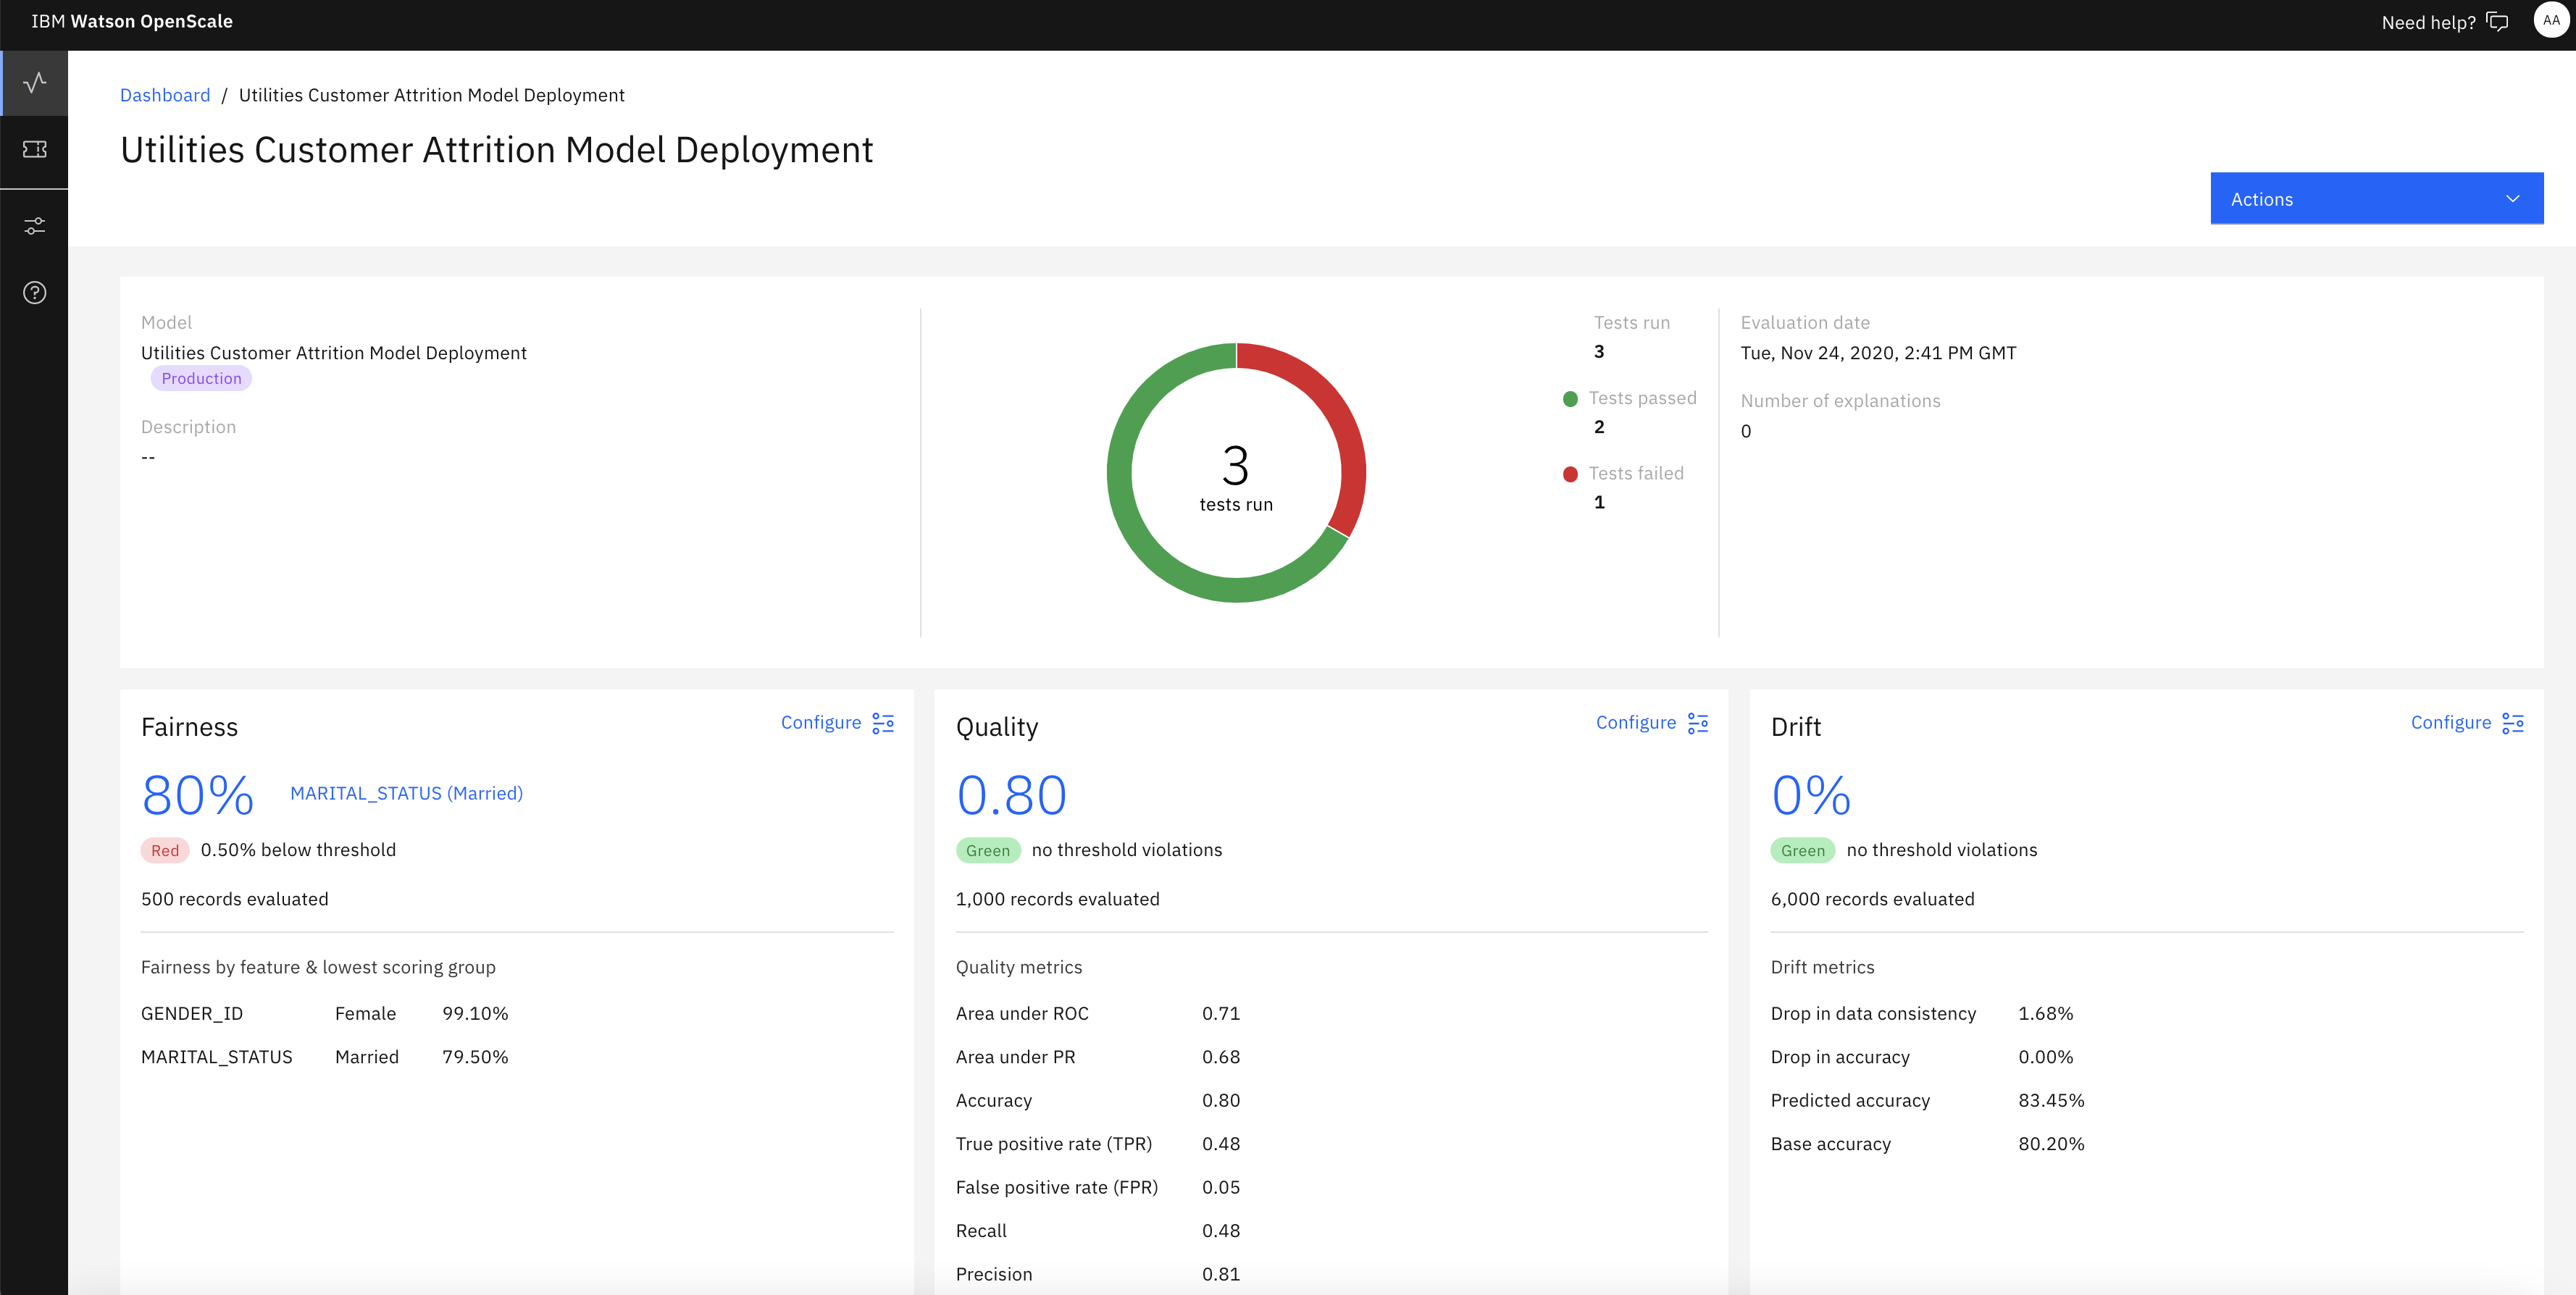

Now see **3-App_deployment** to predict customer attrition on sample data and then deploy r-shiny dashboard